Time taken: 1.18 seconds
Mean Absolute Error: 24.21
Accuracy: 0.78, FP: 0.00, FN: 300.00


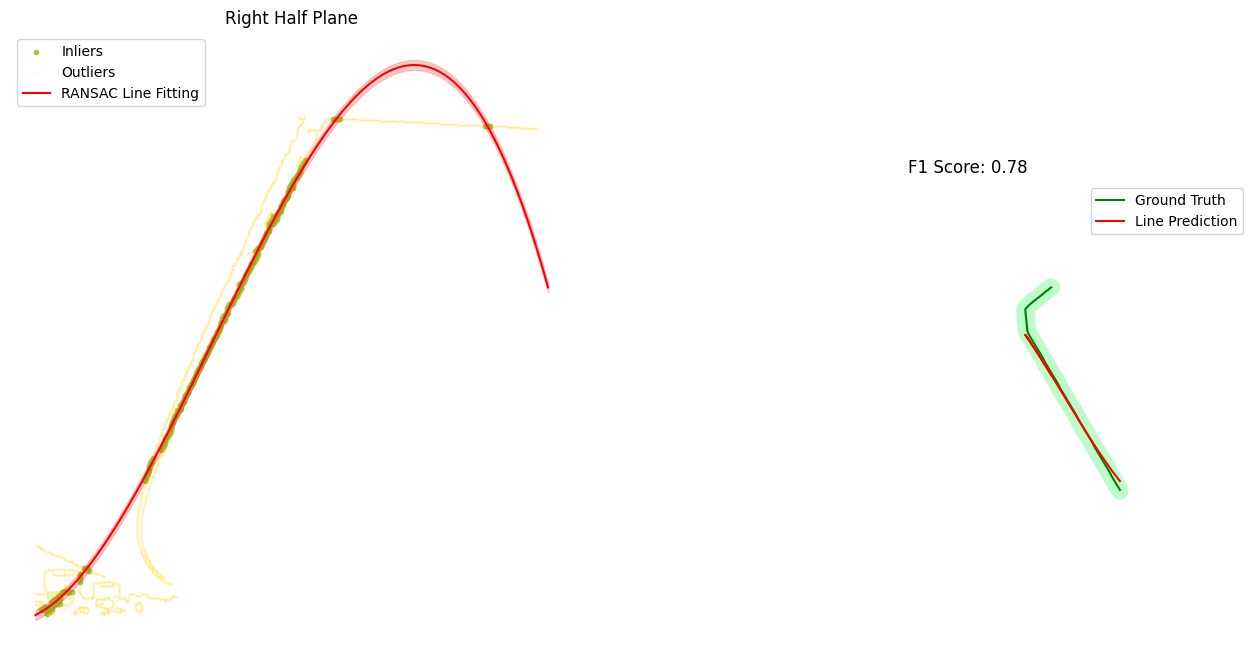

Time taken: 1.12 seconds
Mean Absolute Error: 11.14
Accuracy: 0.94, FP: 84.00, FN: 63.00


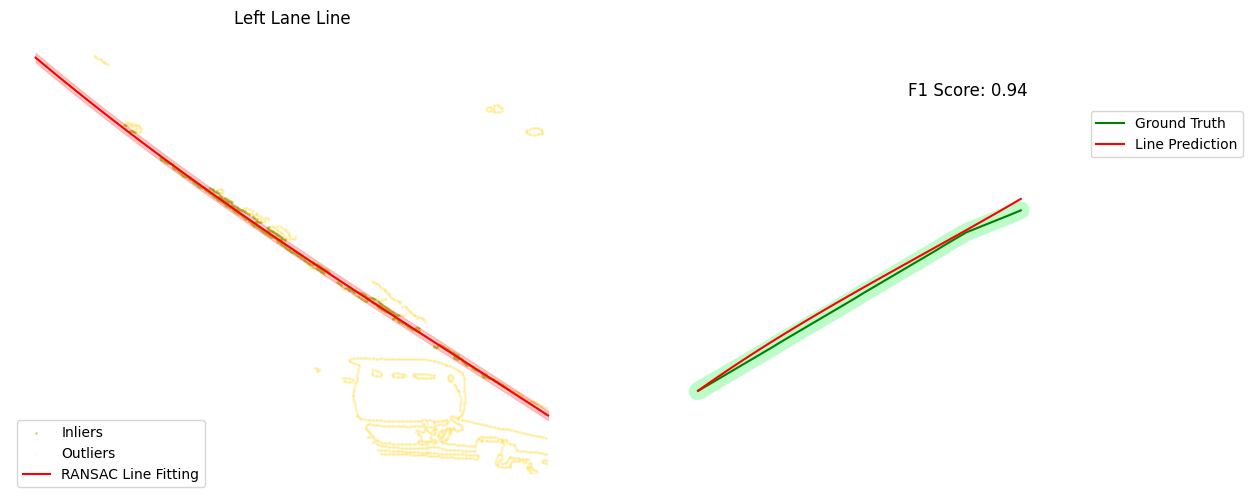

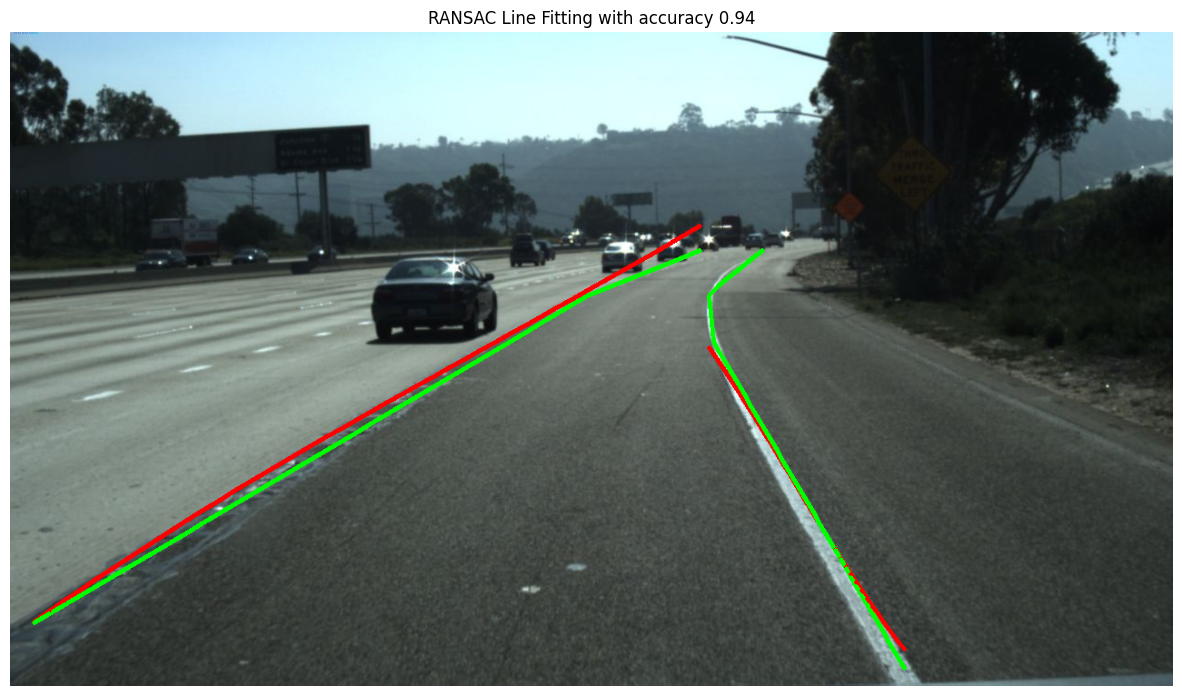

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
import time

image = cv2.imread('../dataset/TUSimple/train_set/clips/0313-1/60/20.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

t_0 = time.time()
# Convert to grayscale
src_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Apply Gaussian 
src_gray = cv2.GaussianBlur(src_gray, (5, 5), 0)

# Apply Canny
src_gray = cv2.Canny(src_gray, 50, 150)

mask = np.zeros_like(src_gray)
ignore_mask_color = 255
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, 220), (800, 220), (imshape[1], imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
edges = cv2.bitwise_and(src_gray, mask)

# Get all the white pixels
white_pixels = np.where(edges == 255)
coords = [(x, y) for (x, y) in zip(white_pixels[1], white_pixels[0])]

# Attempt to fit 2 polynomial lines in the left and right half plane
left_coords = [coord for coord in coords if coord[0] < image.shape[1] / 2]
right_coords = [coord for coord in coords if coord[0] >= image.shape[1] / 2]

# Fit a polynomial line to the right half plane
from sklearn.linear_model import HuberRegressor, RANSACRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

right_x_vals = np.array([coord[0] for coord in right_coords])
y_vals = np.array([coord[1] for coord in right_coords])

ransac = RANSACRegressor(random_state=42, residual_threshold=5.0, max_trials=1000, min_samples=10)
model = make_pipeline(PolynomialFeatures(3), ransac)
model.fit(np.expand_dims(right_x_vals, axis=1), y_vals)

# Get evenly spaced x values
right_x_vals_ = np.linspace(image.shape[1] / 2, image.shape[1], 100)

# Get the predicted y values
right_y_hat = model.predict(np.expand_dims(right_x_vals_, axis=1))

# Get the time taken
t_1 = time.time()
print('Time taken: {:.2f} seconds'.format(t_1 - t_0))

# Read the labeled data
with open('../dataset/TUSimple/train_set/label_data_0313.json') as f:
    # Read Line by Line and convert to json
    for line in f.readlines():
        data = json.loads(line)
        # Find the raw file name
        if data['raw_file'] == 'clips/0313-1/60/20.jpg':
            break
        
# Draw the ground truth
lanes = data['lanes']
ysamples = data['h_samples']
lanes = [[(x, y) for (x, y) in zip(lane, ysamples) if x >= 0] for lane in lanes]

# Compute the mean absolute error
best_x, best_y = [], []
best_y_hat = []
mse = 100000
for lane in lanes:
    if len(lane) < 2:
        continue
    y_hat = model.predict(np.expand_dims(np.array([coord[0] for coord in lane]), axis=1))
    y_lane = np.array([coord[1] for coord in lane])
    if np.mean(np.abs(y_lane - np.array(y_hat))) < mse:
        mse = np.mean(np.abs(y_lane - np.array(y_hat)))
        best_y = np.array([coord[1] for coord in lane])
        best_x = np.array([coord[0] for coord in lane])
        best_y_hat = y_hat
print('Mean Absolute Error: {:.2f}'.format(mse))

# Compute the F1 score using pixel comparison
gt_img = np.zeros_like(image)
gt_img_wide = np.zeros_like(image)
pred_img = np.zeros_like(image)
pred_img_wide = np.zeros_like(image)
for i in range(len(best_x) - 1):
    gt_img_wide = cv2.line(gt_img_wide, (int(best_x[i]), int(best_y[i])), (int(best_x[i + 1]), int(best_y[i + 1])), (255, 255, 255), 40)
    gt_img = cv2.line(gt_img, (int(best_x[i]), int(best_y[i])), (int(best_x[i + 1]), int(best_y[i + 1])), (255, 255, 255), 1)
    pred_img = cv2.line(pred_img, (int(best_x[i]), int(best_y_hat[i])), (int(best_x[i + 1]), int(best_y_hat[i + 1])), (255, 255, 255), 1)
    pred_img_wide = cv2.line(pred_img_wide, (int(best_x[i]), int(best_y_hat[i])), (int(best_x[i + 1]), int(best_y_hat[i + 1])), (255, 255, 255), 40)
tp = np.sum(np.logical_and(gt_img_wide == 255, pred_img == 255))
fp = np.sum(np.logical_and(gt_img_wide == 0, pred_img == 255))
fn = np.sum(np.logical_and(gt_img == 255, pred_img_wide == 0))
accuracy = tp / (tp + fp + fn)
print('Accuracy: {:.2f}, FP: {:.2f}, FN: {:.2f}'.format(accuracy, fp, fn))

# Get inlier and outlier masks
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Plot the left half plane
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(right_x_vals[inlier_mask], y_vals[inlier_mask], color='yellowgreen', marker='.', label='Inliers')
ax[0].scatter(right_x_vals[outlier_mask], y_vals[outlier_mask], color='gold', marker='.', label='Outliers', s=0.05)
ax[0].plot(right_x_vals_, right_y_hat, 'r', label='RANSAC Line Fitting')
ax[0].fill_between(right_x_vals_, right_y_hat - 5.0, right_y_hat + 5.0, color='red', alpha=0.2)
ax[0].set_title('Right Half Plane')
ax[0].legend(loc='upper left')
ax[0].axis('off')
F1_out_img = gt_img_wide.copy()
F1_out_img[np.where((F1_out_img == [255, 255, 255]).all(axis=2))] = [189, 252, 201]
F1_out_img[np.where((F1_out_img == [0, 0, 0]).all(axis=2))] = [255, 255, 255]
ax[1].imshow(F1_out_img)
ax[1].plot(best_x, best_y, 'g', label='Ground Truth')
ax[1].plot(best_x, best_y_hat, 'r', label='Line Prediction')
ax[1].legend(loc='best')
ax[1].set_title('F1 Score: {:.2f}'.format(accuracy))
ax[1].axis('off')
plt.show()

for i in range(len(best_x) - 1):
    # Draw the predicted lane line
    cv2.line(image, (int(best_x[i]), int(best_y_hat[i])), (int(best_x[i + 1]), int(best_y_hat[i + 1])), (255, 0, 0), 3)
    # Draw the ground truth
    cv2.line(image, (int(best_x[i]), int(best_y[i])), (int(best_x[i + 1]), int(best_y[i + 1])), (0, 255, 0), 3)

# Fit a polynomial line to the left half plane
left_x_vals = np.array([coord[0] for coord in left_coords])
y_vals = np.array([coord[1] for coord in left_coords])

# Starting time
t_0 = time.time()

# RANSAC
ransac = RANSACRegressor(random_state=42, residual_threshold=5.0, max_trials=1000)
model = make_pipeline(PolynomialFeatures(3), ransac)
model.fit(np.expand_dims(left_x_vals, axis=1), y_vals)
left_y_hat = model.predict(np.expand_dims(left_x_vals, axis=1))

# Get evenly spaced x values
left_x_vals_ = np.linspace(0, image.shape[1] / 2, 100)
# Get the predicted y values
left_y_hat = model.predict(np.expand_dims(left_x_vals_, axis=1))

# Get the time taken
t_1 = time.time()
print('Time taken: {:.2f} seconds'.format(t_1 - t_0))

# Compute the mean absolute error with the ground truth
best_x, best_y = [], []
best_y_hat = []
mse = 100000
for lane in lanes:
    if len(lane) < 2:
        continue
    y_hat = model.predict(np.expand_dims(np.array([coord[0] for coord in lane]), axis=1))
    y_lane = np.array([coord[1] for coord in lane])
    if np.mean(np.abs(y_lane - np.array(y_hat))) < mse:
        mse = np.mean(np.abs(y_lane - np.array(y_hat)))
        best_y = np.array([coord[1] for coord in lane])
        best_x = np.array([coord[0] for coord in lane])
        best_y_hat = y_hat
print('Mean Absolute Error: {:.2f}'.format(mse))

# Compute the F1 score using pixel comparison
gt_img = np.zeros_like(image)
gt_img_wide = np.zeros_like(image)
pred_img = np.zeros_like(image)
pred_img_wide = np.zeros_like(image)
for i in range(len(best_x) - 1):
    gt_img_wide = cv2.line(gt_img_wide, (int(best_x[i]), int(best_y[i])), (int(best_x[i + 1]), int(best_y[i + 1])), (255, 255, 255), 40)
    gt_img = cv2.line(gt_img, (int(best_x[i]), int(best_y[i])), (int(best_x[i + 1]), int(best_y[i + 1])), (255, 255, 255), 1)
    pred_img = cv2.line(pred_img, (int(best_x[i]), int(best_y_hat[i])), (int(best_x[i + 1]), int(best_y_hat[i + 1])), (255, 255, 255), 1)
    pred_img_wide = cv2.line(pred_img_wide, (int(best_x[i]), int(best_y_hat[i])), (int(best_x[i + 1]), int(best_y_hat[i + 1])), (255, 255, 255), 40)
tp = np.sum(np.logical_and(gt_img_wide == 255, pred_img == 255))
fp = np.sum(np.logical_and(gt_img_wide == 0, pred_img == 255))
fn = np.sum(np.logical_and(gt_img == 255, pred_img_wide == 0))
accuracy = tp / (tp + fp + fn)
print('Accuracy: {:.2f}, FP: {:.2f}, FN: {:.2f}'.format(accuracy, fp, fn))


# Get inlier and outlier masks
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Plot the left half plane RANSAC result and the F1 score
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(left_x_vals[inlier_mask], y_vals[inlier_mask], color='yellowgreen', marker='.', label='Inliers', s=1)
ax[0].scatter(left_x_vals[outlier_mask], y_vals[outlier_mask], color='gold', marker='.', label='Outliers', s=0.05)
ax[0].plot(left_x_vals_, left_y_hat, 'r', label='RANSAC Line Fitting')
ax[0].fill_between(left_x_vals_, left_y_hat - 5.0, left_y_hat + 5.0, color='red', alpha=0.2)
ax[0].set_title('Left Lane Line')
ax[0].legend(loc='best')
ax[0].axis('off')
# Change all white pixels to green and all black pixels to white
F1_out_img = gt_img_wide.copy()
F1_out_img[np.where((F1_out_img == [255, 255, 255]).all(axis=2))] = [189, 252, 201]
F1_out_img[np.where((F1_out_img == [0, 0, 0]).all(axis=2))] = [255, 255, 255]
ax[1].imshow(F1_out_img)
ax[1].plot(best_x, best_y, 'g', label='Ground Truth')
ax[1].plot(best_x, best_y_hat, 'r', label='Line Prediction')
#ax[1].fill_between(best_x, best_y - 20.0, best_y + 20.0, color='green', alpha=0.2)
ax[1].legend(loc='best')
ax[1].set_title('F1 Score: {:.2f}'.format(accuracy))
ax[1].axis('off')
plt.show()

# Draw the predicted lane line
for i in range(len(best_x) - 1):
    # Draw the predicted lane line
    cv2.line(image, (int(best_x[i]), int(best_y_hat[i])), (int(best_x[i + 1]), int(best_y_hat[i + 1])), (255, 0, 0), 3)
    # Draw the ground truth
    cv2.line(image, (int(best_x[i]), int(best_y[i])), (int(best_x[i + 1]), int(best_y[i + 1])), (0, 255, 0), 3)
    
# Show result and canny image for comparison
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(image)
ax.set_title('RANSAC Line Fitting with accuracy {:.2f}'.format(accuracy))
ax.axis('off')
plt.show()


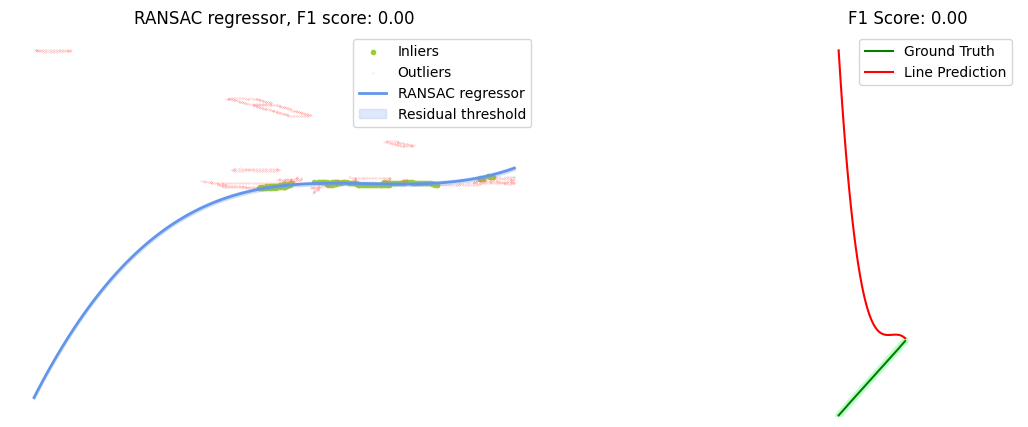

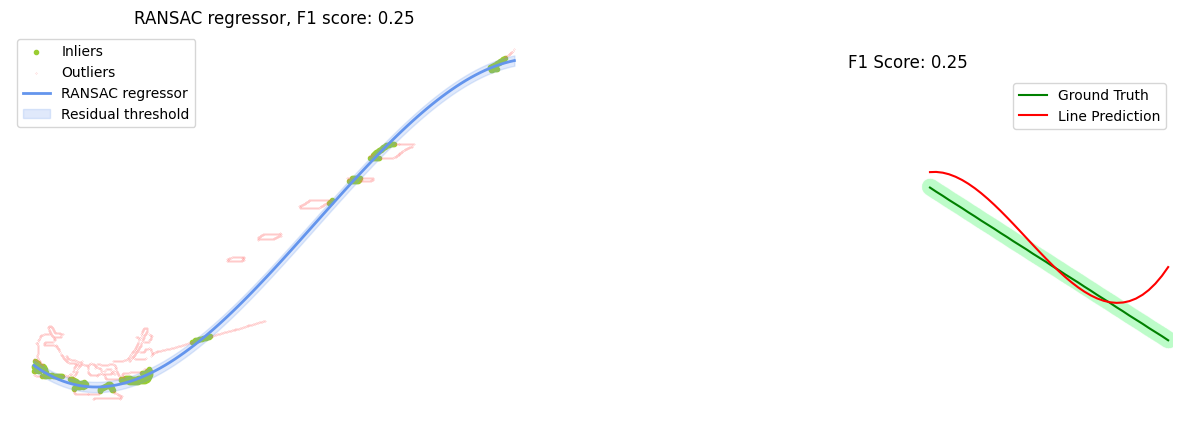

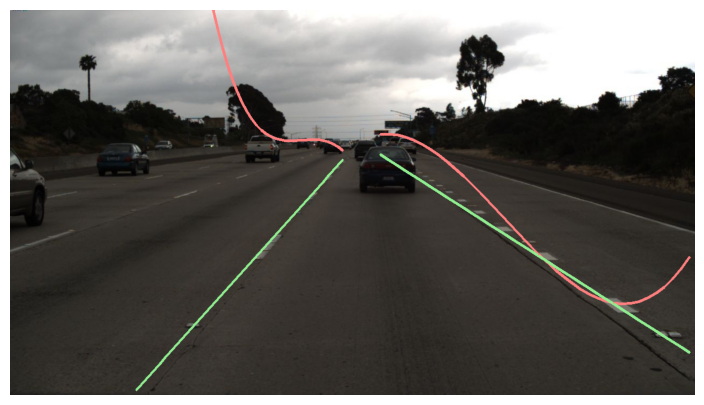

In [7]:
import QuickFit as qf
import matplotlib.pyplot as plt
import numpy as np

# Set up quick fig
QF = qf.QuickFit(ransac_max_trials=10)

# Load the image
image = qf.QuickFit.load_image('../dataset/TUSimple/train_set/clips/0601/1494452397586667021/20.jpg')

# Load the labeled data
label_coords = qf.QuickFit.load_labels('../dataset/TUSimple/train_set/label_data_0313.json', 'clips/0601/1494452397586667021/20.jpg')

# Apply the filter
pixels = QF.apply_filter(image)

# Split the pixels into left and right half planes
left_pixels, right_pixels = qf.QuickFit.split_pixels(pixels, image)

# Fit a polynomial line to the left half plane
left_model = QF.fit_line(left_pixels)
right_model = QF.fit_line(right_pixels)

# Get the predicted y values for the left and right half planes
min_x = np.min(left_pixels[:, 0])
max_x = np.max(left_pixels[:, 0])
left_y_hat = qf.QuickFit.predict_line(left_model, (min_x, max_x))
min_x = np.min(right_pixels[:, 0])
max_x = np.max(right_pixels[:, 0])
right_y_hat = qf.QuickFit.predict_line(right_model, (min_x, max_x))

# Get the predicted lane lines
left_lane, left_pred_lane = qf.QuickFit.get_best_MSE(label_coords, left_model)
right_lane, right_pred_lane = qf.QuickFit.get_best_MSE(label_coords, right_model)

# Render the result
left_fig = QF.render_RANSAC(left_y_hat, left_pred_lane, left_lane, left_pixels, left_model, image)
right_fig = QF.render_RANSAC(right_y_hat, right_pred_lane, right_lane, right_pixels, right_model, image)

# Draw the predicted lane line
main_fig = qf.QuickFit.draw_lines(image, left_lane, left_pred_lane, right_lane, right_pred_lane)
# Show the result
#left_fig.show()
#right_fig.show()